In [102]:
#Imports necessary libraries
import pandas as pd
import sqlite3
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [4]:
#Load all data as dataframes
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
name_basics = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
title_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
title_basics= pd.read_csv('zippedData/imdb.title.basics.csv.gz')
title_crew = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
title_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
title_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', '\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', '\t', encoding='windows-1252')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [5]:
#Reformat movie_budgets['production_budget'] as int64
movie_budgets['production_budget'] = movie_budgets['production_budget'].map(lambda x: x.strip('$'))
movie_budgets['production_budget'] = movie_budgets['production_budget'].map(lambda x: x.replace(',', ''))
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype('int64')
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(2), object(4)
memory usage: 271.2+ KB


In [6]:
#Reformat movie_budgets['domestic_gross'] as int64
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].map(lambda x: x.strip('$'))
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].map(lambda x: x.replace(',', ''))
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype('int64')
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   object
dtypes: int64(3), object(3)
memory usage: 271.2+ KB


In [7]:
#Reformat movie_budgets['worldwide_gross'] as int64
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].map(lambda x: x.strip('$'))
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].map(lambda x: x.replace(',', ''))
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype('int64')
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


In [8]:
#create new column for the month of release
movie_budgets['release_month'] = movie_budgets['release_date'].apply(lambda x: x[:3])

In [9]:
#create profit column
movie_budgets['profit'] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_month,profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,Dec,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,May,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,Jun,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,May,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Dec,999721747


In [10]:
#introduce pandas query function
pysqldf = lambda q: sqldf(q, globals())

In [11]:
#create DataFrame from multiple df's with introduced query function
table1 = pysqldf('''select original_title, primary_title, primary_name, production_budget, worldwide_gross, genres, category, runtime_minutes, averagerating, numvotes, profit, release_month
                    from movie_budgets mb
                    join title_basics tb
                    on mb.movie == tb.primary_title
                    join title_principals
                    using(tconst)
                    join title_ratings
                    using (tconst)
                    join name_basics
                    using(nconst)''')

In [37]:
#Creates table of Actors and average profit with number of movies
actors = pysqldf('''select primary_name, avg(profit) / 1000000 as avg_profit, count(primary_name) as num_movies
           from table1
           group by primary_name
           having count(primary_title) > 10 and (category == 'actor' or category == 'actress')  
           order by avg(profit) desc
           limit 20''')
actors

,primary_name,avg_profit,num_movies
0,Robert Downey Jr.,704.306889,11
1,Chris Evans,450.098482,13
2,Dwayne Johnson,329.997203,19
3,Chris Hemsworth,325.937533,14
4,Scarlett Johansson,325.108469,12
5,Cate Blanchett,271.737861,12
6,Kristen Wiig,268.578719,12
7,Anne Hathaway,257.660083,13
8,Jennifer Lawrence,241.432788,15
9,Jason Statham,236.651372,13


[Text(0, 0.5, 'Profit in Millions'),
 Text(0.5, 0, 'Actor Names'),
 Text(0.5, 1.0, 'Most Profitable Actors')]

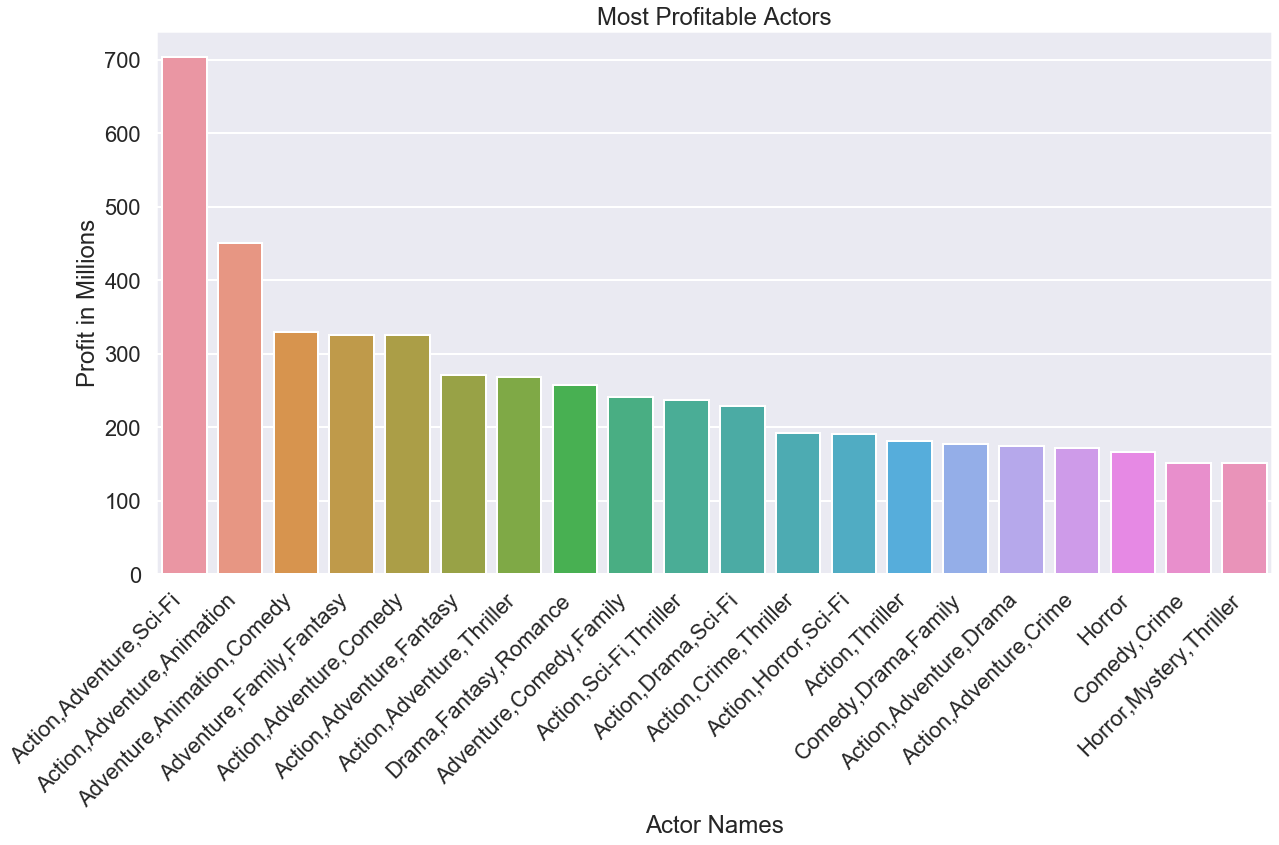

In [62]:
#Charts most profitable actors
sns.set(style = 'darkgrid', context = 'poster')
plt.figure(figsize=(20,10))
actorsChart = sns.barplot(data=actors, x='primary_name', y='avg_profit')
actorsChart.set_xticklabels(totalsChart.get_xticklabels(), rotation=45, horizontalalignment='right')
actorsChart.set(title = 'Most Profitable Actors', xlabel='Actor Names', ylabel='Profit in Millions')

In [73]:
#genre table
genre_table = table1
print("genre_table shape: " + str(genre_table.shape))
print("genre_table columns: " + str(genre_table.columns))

genre_table shape: (27145, 12)
genre_table columns: Index(['original_title', 'primary_title', 'primary_name', 'production_budget',
       'worldwide_gross', 'genres', 'category', 'runtime_minutes',
       'averagerating', 'numvotes', 'profit', 'release_month'],
      dtype='object')


In [74]:
#remove the unnecessary columns in the data set (i.e. ones that arent genre and profit)
drop_col = ['original_title', 'primary_name', 'production_budget',
       'worldwide_gross', 'category', 'runtime_minutes',
       'averagerating', 'numvotes', 'release_month']
genre_table = genre_table.drop(drop_col, axis=1)
print("genre_table shape: " + str(genre_table.shape))

genre_table shape: (27145, 3)


In [75]:
#remove the rows in the table that repeat movies
genre_table = genre_table.drop_duplicates()
print("genre_table shape: " + str(genre_table.shape))
genre_table.head()

genre_table shape: (2785, 3)


,primary_title,genres,profit
0,Avatar,Horror,2351345279
10,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",635063875
20,Dark Phoenix,"Action,Adventure,Sci-Fi",-200237650
30,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",1072413963
40,Avengers: Infinity War,"Action,Adventure,Sci-Fi",1748134200


In [76]:
#reset the index for the table that has no repeat movies (gT1)
genre_table.index = [x for x in range(1, len(genre_table.values)+1)]
print("number of unique genres: " + str(genre_table['genres'].nunique()))
genre_table.head()

number of unique genres: 311


,primary_title,genres,profit
1,Avatar,Horror,2351345279
2,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",635063875
3,Dark Phoenix,"Action,Adventure,Sci-Fi",-200237650
4,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",1072413963
5,Avengers: Infinity War,"Action,Adventure,Sci-Fi",1748134200


In [79]:
#We only took genres with atleast 10 movies
#Creates a table of genres and average profit
final_genre_table = pysqldf("""select genres, count(genres) as gen, avg(profit) /1000000 as avg_profit
            from genre_table
            group by genres
            having gen >= 10
            order by avg(profit) DESC
            limit 20""")
final_genre_table

,genres,gen,avg_profit
0,"Action,Adventure,Sci-Fi",58,438.519862
1,"Action,Adventure,Animation",17,322.257606
2,"Adventure,Animation,Comedy",73,278.728221
3,"Adventure,Family,Fantasy",16,239.937417
4,"Action,Adventure,Comedy",30,235.610011
5,"Action,Adventure,Fantasy",40,217.793945
6,"Action,Adventure,Thriller",14,216.969605
7,"Drama,Fantasy,Romance",10,180.036083
8,"Adventure,Comedy,Family",13,136.228258
9,"Action,Sci-Fi,Thriller",13,121.580853


[Text(0, 0.5, 'Profit in Millions'),
 Text(0.5, 0, 'Genres'),
 Text(0.5, 1.0, 'Most Profitable Genres')]

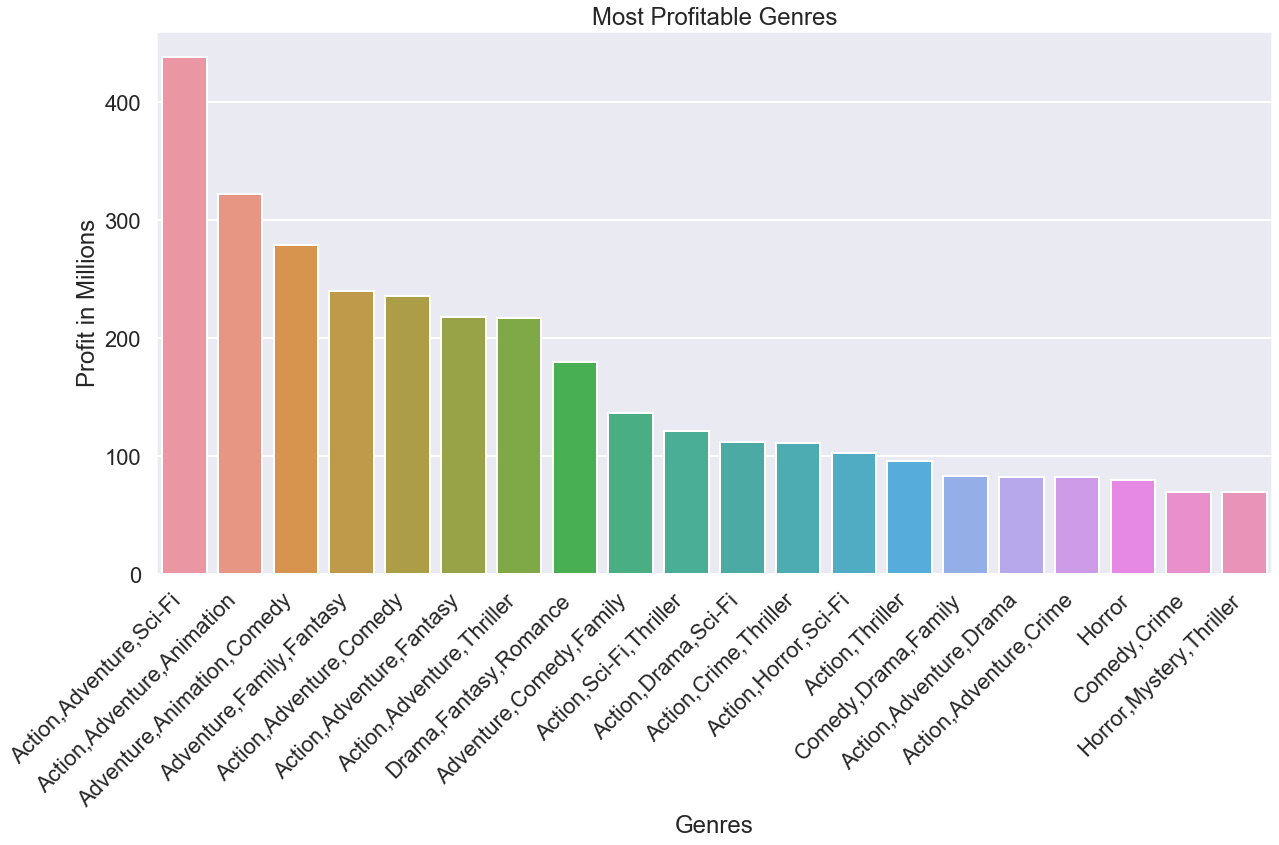

In [80]:
sns.set(style="darkgrid", context  = 'poster')
plt.figure(figsize=(20,10))
genresChart = sns.barplot(data=final_genre_table, x='genres',y='avg_profit')
genresChart.set_xticklabels(totalsChart.get_xticklabels(), rotation=45, horizontalalignment='right')
genresChart.set(title = 'Most Profitable Genres', xlabel='Genres', ylabel='Profit in Millions')

In [113]:
#Finds correlation between average rating and profit
rating_clean = table1[{'averagerating', 'profit'}]
rating_clean.profit = rating_clean.profit / 1000000
rating_clean.corr()

/Users/ericadsetts/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,profit,averagerating
profit,1.000000,0.173084
averagerating,0.173084,1.000000


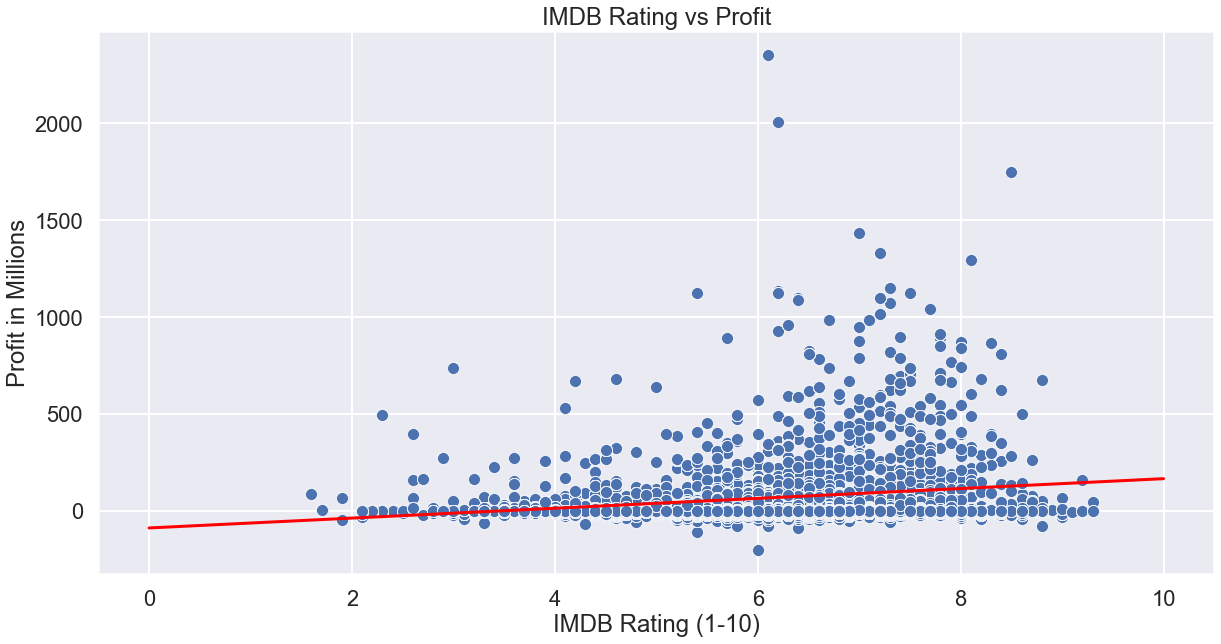

In [117]:
#Plot imdb rating vs profit along with trend line
sns.set(style="darkgrid", context  = 'poster')
plt.figure(figsize=(20,10))
ratingsChart = sns.scatterplot(data=rating_clean, x='averagerating',y='profit')
ratingsChart.set(title = 'IMDB Rating vs Profit', xlabel='IMDB Rating (1-10)', ylabel='Profit in Millions')
x = rating_clean.averagerating
y = rating_clean.profit
p = np.poly1d(np.polyfit(x,y,1))
xp = np.linspace(0,10,100)
ratingsChart.plot(xp,p(xp), color = 'red')

In [119]:
print(len(table1[{'runtime_minutes', 'profit'}]))
print(table1[{'runtime_minutes', 'profit'}].isna().sum())
runtime_clean = table1[{'runtime_minutes', 'profit'}].dropna()
runtime_clean.profit = runtime_clean.profit /1000000
len(runtime_clean)
runtime_clean.corr()

27145
runtime_minutes    977
profit               0
dtype: int64


,runtime_minutes,profit
runtime_minutes,1.000000,0.189827
profit,0.189827,1.000000


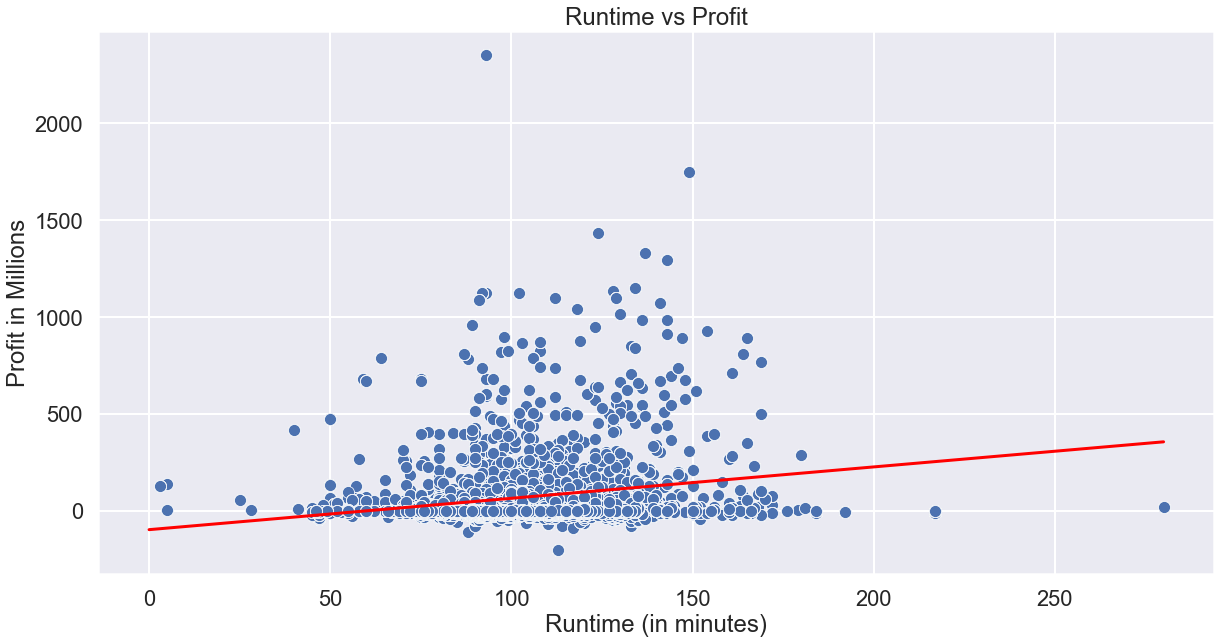

In [122]:
#Plot imdb rating vs profit along with trend line
sns.set(style="darkgrid", context  = 'poster')
plt.figure(figsize=(20,10))
runtimeChart = sns.scatterplot(data=runtime_clean, x='runtime_minutes',y='profit')
runtimeChart.set(title = 'Runtime vs Profit', xlabel='Runtime (in minutes)', ylabel='Profit in Millions')
x = runtime_clean.runtime_minutes
y = runtime_clean.profit
p = np.poly1d(np.polyfit(x,y,1))
xp = np.linspace(0,280,100)
runtimeChart.plot(xp,p(xp), color = 'red')